In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import atom_functions as atom

## instantiate an at dataset 

In [2]:
test = atom.dataset('/Users/nhamilto/Documents/ATom/data/new_data/')
test.load_data_sample(0)

### extract travel times for a few upsample factors

In [3]:
atomsigs1, tt1, tr1 = test.extract_travel_times(upsamplefactor=1)
atomsigs5, tt5, tr5 = test.extract_travel_times(upsamplefactor=5)
atomsigs10, tt10, tr10 = test.extract_travel_times(upsamplefactor=10)

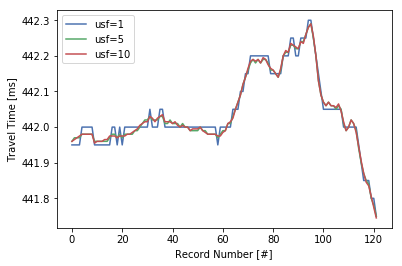

In [23]:
spknum = 'S{}'.format(np.random.randint(0,8,1)[0])
micnum = 'M{}'.format(np.random.randint(0,8,1)[0])

tmp1 = tt1.loc[(spknum, micnum)].values # np.squeeze(tt1[spknum, micnum, :])
tmp5 = tt5.loc[(spknum, micnum)].values # np.squeeze(tt5[spknum, micnum, :])
tmp10 = tt10.loc[(spknum, micnum)].values # np.squeeze(tt10[spknum, micnum, :])

fig,ax = plt.subplots()
ax.plot(tmp1, label='usf=1')
ax.plot(tmp5, label='usf=5')
ax.plot(tmp10, label='usf=10')
ax.set_xlabel('Record Number [#]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

In [22]:
speakersamp = test.speaker_data.xs('record 0', level=0)
delays = atom.get_speaker_signal_delay(speakersamp)

KeyError: 'record 0'

In [22]:
delays


array([2480, 2080, 4080,    0, 3200, 4000,  800, 2880])

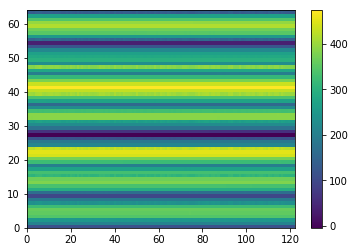

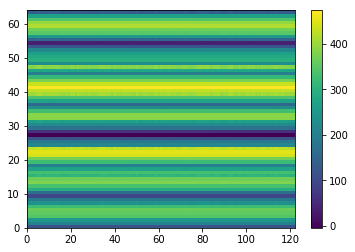

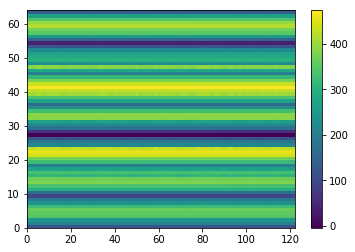

In [14]:
fig,ax1 = plt.subplots()
tra = tt1.reshape(64,122)
p1=ax1.pcolor(tra)
fig.colorbar(p1)

fig,ax2 = plt.subplots()
tra = tt5.reshape(64,122)
p1=ax2.pcolor(tra)
fig.colorbar(p1)

fig,ax2 = plt.subplots()
tra = tt10.reshape(64,122)
p1=ax2.pcolor(tra)
fig.colorbar(p1)


In [124]:
micsamp = test.mic_data.xs('record 1', level=0)
miscamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
speakersamp = test.speaker_data.xs('record 1', level=0)
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)
upsamplefactor=1
searchLag = 3 * test.meta.chirp_record_length * upsamplefactor


In [135]:
ups = atom.upsample(speakersamp, 5)

In [187]:
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)*5
# print(speaker_signal_delay*5)
# speaker_signal_delay = atom.get_speaker_signal_delay(ups)
print(speaker_signal_delay)

[12400 10400 20400     0 16000 20000  4000 14400]


In [153]:
for ic, col in enumerate(speakersamp.columns):
    speaker_signal_delay[ic] = ups[col].nonzero()[0][0] 
speaker_signal_delay = speaker_signal_delay.astype(int)

In [154]:
speaker_signal_delay

array([ 9611,  7611, 17611,     1, 13211, 17211,  1211, 11611])

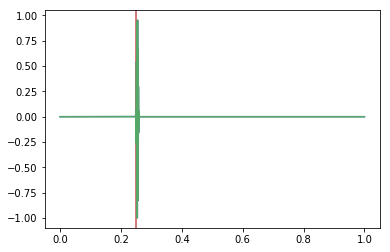

In [188]:
fig,ax = plt.subplots()
ax.plot(np.arange(0,1,1/len(ups.iloc[:,0])),ups.iloc[:, 0].values)
ax.axvline(speaker_signal_delay[0]/ups.shape[0], color='C2')
# ax.set_xlim(12000,13500)
ax.plot(np.arange(0,1,1/len(speakersamp.iloc[:,0])),speakersamp.iloc[:,0].values)

record: 1
eta - obs: 39.0


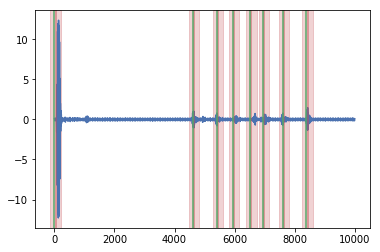

In [4]:
fig,ax = plt.subplots()
recnum = np.random.randint(0, 122, 1)[0]
micsamp = test.mic_data.xs('record {}'.format(recnum), level=0)
micsamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
micnum=3
ax.plot(micsamp['M{}'.format(micnum)].values)
for ii in range(8):
    ax.axvline(test.signalETAs[ii,micnum], color='C2', alpha=0.6)
    start = (test.signalETAs[ii,micnum]+(0*test.meta.chirp_record_length - searchLag) / 2).astype(int)
    stop = start + searchLag
    ax.axvspan(start,stop, alpha=0.25, color ='C2')
    ax.axvline(tr[ii,micnum,recnum], color='C1')

# ax.set_xlim(0,500)
print('record: {}'.format(recnum))
print('eta - obs: {}'.format((test.signalETAs[:,micnum] - tr[:, micnum,recnum]).mean()))


In [82]:
jtt = np.genfromtxt('../ttout.txt')
srout = np.load('../s_rout.npy')

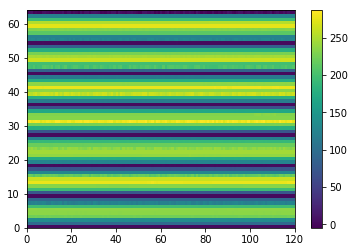

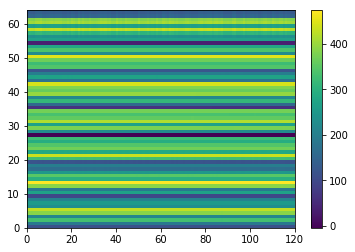

In [45]:
fig,ax = plt.subplots()
aa = ax.pcolor(jtt)
fig.colorbar(aa)

fig,ax = plt.subplots()
aa=ax.pcolor(tt.swapaxes(0,1).reshape(64,122)[:,:-2])
fig.colorbar(aa)


In [53]:
channelnum

array([16])

Text(0,0.5,'james')

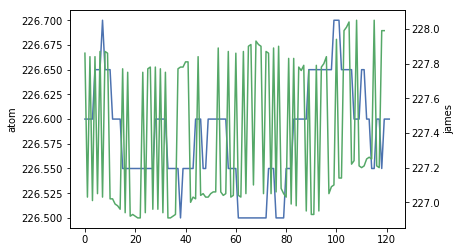

In [58]:
speakernum = np.random.randint(0,8,1)
micnum = np.random.randint(0,8,1)

channelnum = int(8*speakernum + micnum)

fig,ax = plt.subplots()
ax.plot(tt.swapaxes(0,1).reshape(64,122)[channelnum,:].T)
ax.set_ylabel('atom')
ax2 = ax.twinx()
ax2.plot(jtt[channelnum,:],color='C1')
ax2.set_ylabel('james')


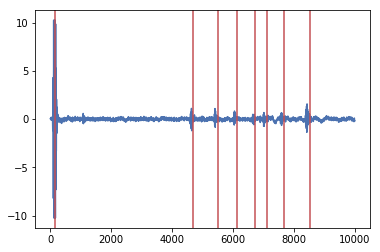

In [35]:
recordnum = 4
mictest = test.mic_data.xs('record {}'.format(recordnum), level=0)
fig, ax = plt.subplots()
ax.plot(mictest['M3'].values)
for jj in range(8):
    ax.axvline(tr[3,jj,recordnum],color='C2')

In [28]:
tr.reshape(64,122)[27,:-2].mean(-1)

81.56666666666666

In [30]:
test.signalETAs

array([[2522, 3935, 6747, 4493, 7956, 8817, 4851, 5376],
       [4388, 2122, 5497, 3890, 7890, 9596, 6143, 7184],
       [5214, 3581, 4122, 2477, 6655, 8821, 5813, 7583],
       [7001, 6030, 6621,   42, 4566, 7573, 5402, 8422],
       [7252, 6823, 7593, 1446, 3241, 6300, 4423, 8009],
       [7276, 7699, 8931, 3639, 5573, 4042, 2472, 6847],
       [6486, 7421, 9096, 4649, 6881, 5749,  841, 5350],
       [4900, 6343, 8744, 5549, 8350, 8020, 3338, 2922]])

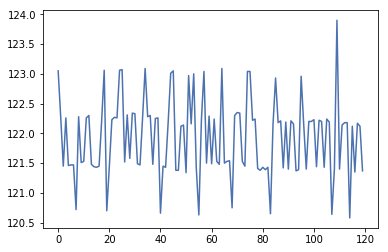

In [33]:

plt.plot(tr.reshape(64,122)[26,:-2])
plt.plot(jtt[26,:])#/(1000*test.meta.main_delta_t))

In [25]:
test.meta.main_delta_t

0.05

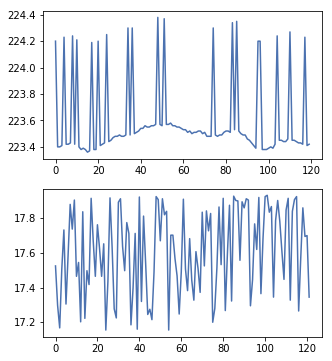

In [17]:
times = np.swapaxes(tt,0,1).reshape(64,122)*test.meta.main_delta_t

ii = 3
fig,ax = plt.subplots(2,1, figsize=(5,6))
ax[0].plot(jtt[ii,:])
ax[1].plot(times[ii,:])
# 


In [4]:
micsamp = test.mic_data.xs('record 0', level=0)
speakersamp = test.speaker_data.xs('record 0', level=0)

In [5]:
import imp
imp.reload(atom)

<module 'atom_functions_v1' from '/Users/nhamilto/Documents/ATom/coderepo/atom_functions_v1.py'>

In [6]:
micsamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)

(7500, 8250)

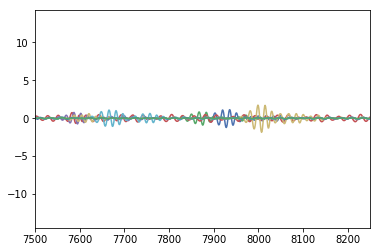

In [10]:
fig, ax = plt.subplots()
ax.plot(micsamp.values)
ax.set_xlim(7500, 8250)

In [11]:
m1 = micsamp['M0']
s1 = speakersamp['S0']

In [13]:
covar = atom.covariance(micsamp, speakersamp)

In [27]:
c1 = covar[0,0,:]
c1r = np.roll(c1,int(len(c1)/2))

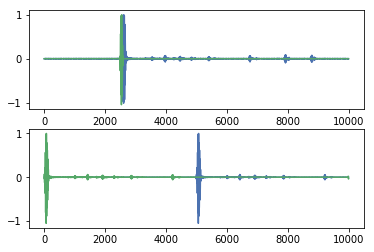

In [28]:
fig, ax = plt.subplots(2,1)

ax[0].plot(m1.values/m1.max())
ax[0].plot(s1.values/s1.max())
ax[1].plot(c1/c1.max())
ax[1].plot(c1r/c1.max())

# ax.set_xlim(7500, 8250)


In [29]:
np.argmax(c1)

5073

In [39]:
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)
signalETAs = (speaker_signal_delay + test.ETAs_index.T).T

In [40]:
signalETAs

array([[2480, 2482, 2483, 2484, 2485, 2485, 2484, 2482],
       [2082, 2080, 2081, 2084, 2085, 2086, 2085, 2084],
       [4083, 4082, 4080, 4082, 4083, 4085, 4085, 4085],
       [   5,    4,    3,    0,    1,    4,    5,    6],
       [3205, 3205, 3204, 3201, 3200, 3202, 3204, 3205],
       [4005, 4006, 4005, 4004, 4002, 4000, 4002, 4004],
       [ 804,  805,  805,  805,  804,  802,  800,  802],
       [2882, 2884, 2885, 2886, 2885, 2884, 2883, 2880]])

In [45]:
test.ETAs_index

array([[0, 2, 3, 4, 5, 5, 4, 2],
       [2, 0, 1, 4, 5, 6, 5, 4],
       [3, 2, 0, 2, 3, 5, 5, 5],
       [5, 4, 3, 0, 1, 4, 5, 6],
       [5, 5, 4, 1, 0, 2, 4, 5],
       [5, 6, 5, 4, 2, 0, 2, 4],
       [4, 5, 5, 5, 4, 2, 0, 2],
       [2, 4, 5, 6, 5, 4, 3, 0]])

In [57]:
(test.ETAs_time/(test.meta.main_delta_t/1000)).round().astype(int)

array([[  42, 1855, 2667, 4493, 4756, 4817, 4051, 2496],
       [1908,   42, 1417, 3890, 4690, 5596, 5343, 4304],
       [2734, 1501,   42, 2477, 3455, 4821, 5013, 4703],
       [4521, 3950, 2541,   42, 1366, 3573, 4602, 5542],
       [4772, 4743, 3513, 1446,   41, 2300, 3623, 5129],
       [4796, 5619, 4851, 3639, 2373,   42, 1672, 3967],
       [4006, 5341, 5016, 4649, 3681, 1749,   41, 2470],
       [2420, 4263, 4664, 5549, 5150, 4020, 2538,   42]])

In [ ]:
test.ETAs_index + 

In [51]:
signalstarts = np.array([int(s) if s > 0 else 0 for s in (test.ETAs_index[:,0] + test.meta.chirp_record_length) ])#-


# for si in range(8):
#     startind = test.ETAs_index[si,0]
    
#     print(np.argmax(c1r[]))

In [52]:
signalstarts

array([116, 118, 119, 121, 121, 121, 120, 118])

In [32]:
upsamplefactor=1
searchLag = 3 * test.meta.chirp_record_length * upsamplefactor

In [33]:
test.ETAs_index

array([[0, 2, 3, 4, 5, 5, 4, 2],
       [2, 0, 1, 4, 5, 6, 5, 4],
       [3, 2, 0, 2, 3, 5, 5, 5],
       [5, 4, 3, 0, 1, 4, 5, 6],
       [5, 5, 4, 1, 0, 2, 4, 5],
       [5, 6, 5, 4, 2, 0, 2, 4],
       [4, 5, 5, 5, 4, 2, 0, 2],
       [2, 4, 5, 6, 5, 4, 3, 0]])

In [34]:
searchLag

348